In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, confusion_matrix, classification_report, roc_auc_score


## `LOADING THE DATASET`

In [67]:
df_corona = pd.read_csv('data.csv')
print('Shape: ' + str(df_corona.shape))
df_corona.head()

Shape: (863, 15)


,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


## `split data into X,Y`

In [68]:
X = df_corona.drop(columns=['result','Unnamed: 0'])
Y = df_corona['result']

## `Split data into train, test`
- ### for validation cross validation will be used

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3, stratify=Y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape
## gonna use corss-validation

((690, 13), (173, 13), (690,), (173,))

Data already cleand and no need to preprocessing so lest go through first model
## 1. K-Nearest Neighbors

In [70]:
ks = np.arange(start=1, stop=15, step=2)
acc_knn = []
for i in ks:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    cv_y_train__hat = cross_val_predict(estimator=knn, X=X_train,y=y_train, cv=5, n_jobs=-1)
    acc_knn.append(accuracy_score(y_train, cv_y_train__hat))

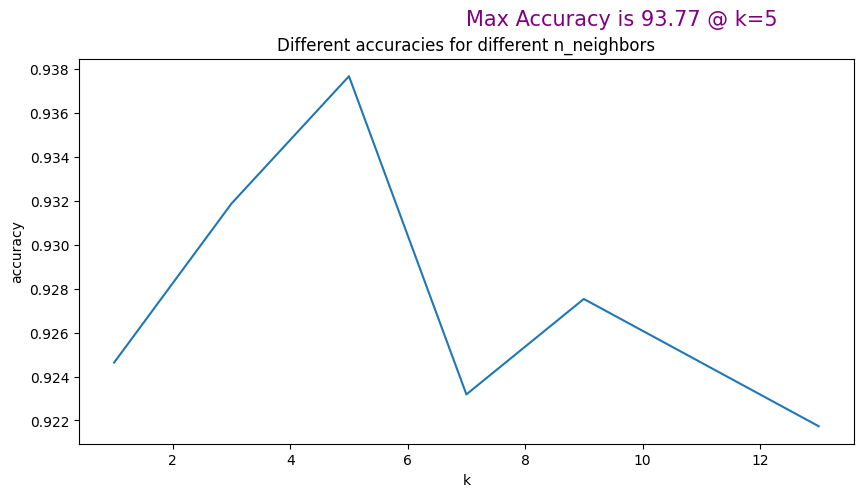

In [71]:
best_k = ks[np.argmax(acc_knn)]
best_acc = np.max(acc_knn)

plt.figure(figsize=(10,5))
plt.plot(ks, acc_knn)
plt.title("Different accuracies for different n_neighbors")
plt.xlabel('k')
plt.ylabel('accuracy')
plt.text(x=7, y=0.94, s='Max Accuracy is '+str(round(best_acc*100,2)) + ' @ k='+str(best_k), size=15, color='purple')
plt.show()

- for now lets train KNN model on full training data with best_k

In [72]:
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(X_train, y_train)
y_train_hat_knn = knn.predict(X_train)
y_test_hat_knn = knn.predict(X_test)

y_train_hat_knn_proba = knn.predict_proba(X_train)
y_test_hat_knn_proba = knn.predict_proba(X_test)

## 2. Logistic Regression

In [73]:
lrs = np.linspace(0.001, 1.1, 40)
acc_logreg = []
logreg = LogisticRegression(max_iter=1000000, random_state=3)
grid = {'solver':['newton-cg', 'lbfgs', 'liblinear'],
        'penalty':['l2'],
        'C':[100, 10, 1.0, 0.1, 0.01]}

grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
grid_result.best_score_

0.9405797101449276

- for now lets best train Logistic Regression model on full training data with best_lr

In [74]:
logreg = grid_result.best_estimator_
logreg.fit(X_train, y_train)
y_train_hat_logreg = logreg.predict(X_train)
y_test_hat_logreg = logreg.predict(X_test)

y_train_hat_logreg_proba = logreg.predict_proba(X_train)
y_test_hat_logreg_proba = logreg.predict_proba(X_test)

## 3. Gaussian Naïve Bayes


In [75]:
vars = np.logspace(0,-9, num=100)
acc_nb = []
for i in vars:
    nb = GaussianNB(var_smoothing=i)
    cv_y_train__hat = cross_val_predict(estimator=nb, X=X_train,y=y_train, cv=5, n_jobs=-1)
    acc_nb.append(accuracy_score(y_train, cv_y_train__hat))

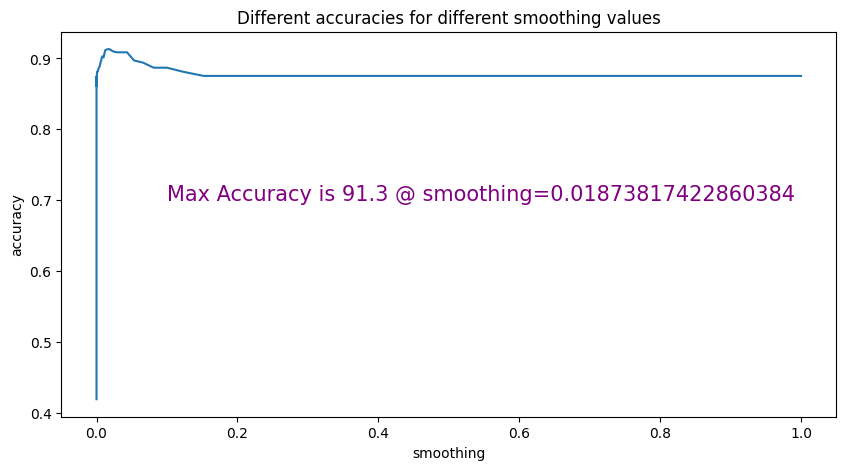

In [76]:
best_var = vars[np.argmax(acc_nb)]
best_acc = np.max(acc_nb)

plt.figure(figsize=(10,5))
plt.plot(vars, acc_nb)
plt.title("Different accuracies for different smoothing values")
plt.xlabel('smoothing')
plt.ylabel('accuracy')
plt.text(x=0.1, y=0.7, s='Max Accuracy is '+str(round(best_acc*100,2)) + ' @ smoothing='+str(best_var), size=15, color='purple')
plt.show()

- for now lets train NB model on full training data with best_var_smoothing value

In [77]:
nb = GaussianNB(var_smoothing=best_var)
nb.fit(X_train, y_train)
y_train_hat_nb = nb.predict(X_train)
y_test_hat_nb = nb.predict(X_test)

y_train_hat_nb_proba = nb.predict_proba(X_train)
y_test_hat_nb_proba = nb.predict_proba(X_test)

# 4. Decision Trees

In [78]:
depths = np.arange(1, 20, 1)
acc_dt = []
for i in depths:
    tree = DecisionTreeClassifier(max_depth=i, random_state=3)
    cv_y_train__hat = cross_val_predict(estimator=tree, X=X_train,y=y_train, cv=5, n_jobs=-1)
    acc_dt.append(accuracy_score(y_train, cv_y_train__hat))

- now lets train the decisoin tree model on full training data with best depth value

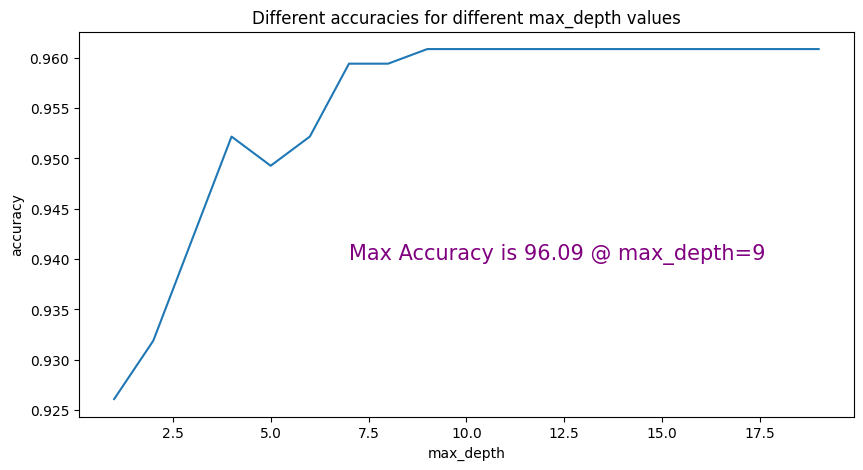

In [79]:
best_depth = depths[np.argmax(acc_dt)]
best_acc = np.max(acc_dt)

plt.figure(figsize=(10,5))
plt.plot(depths, acc_dt)
plt.title("Different accuracies for different max_depth values")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.text(x=7, y=0.94, s='Max Accuracy is '+str(round(best_acc*100,2)) + ' @ max_depth='+str(best_depth), size=15, color='purple')
plt.show()


In [80]:
dt = DecisionTreeClassifier(max_depth=best_depth, random_state=3)
dt.fit(X_train, y_train)
y_train_hat_dt = dt.predict(X_train)
y_test_hat_dt = dt.predict(X_test)

y_train_hat_dt_proba = dt.predict_proba(X_train)
y_test_hat_dt_proba = dt.predict_proba(X_test)

# 5. SVM

In [81]:
svms = np.linspace(0.001, 1.1, 40)
acc_svm = []
svm = svm.SVC(probability=True, random_state=3)
grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'C':[100, 10, 1.0, 0.1, 0.01],
        'gamma':['scale']}
grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
grid_result.best_score_


0.9434782608695652

- now lets train the decisoin tree model on full training data with best depth value

In [82]:
svm = grid_result.best_estimator_
svm.fit(X_train, y_train)
y_train_hat_svm = svm.predict(X_train)
y_test_hat_svm = svm.predict(X_test)

y_train_hat_svm_proba = svm.predict_proba(X_train)
y_test_hat_svm_proba = svm.predict_proba(X_test)

### Metrics for Training set

In [83]:
metrics_train = {'Metric':['Accuracy', 'precision', 'recall', 'F1_score', 'AUC'],
                'KNN':[],
                'LogReg':[],
                'NB':[],
                'DecisionTree':[],
                'SVM':[]}
# Accuracy
metrics_train['KNN'].append(accuracy_score(y_train, y_train_hat_knn))
metrics_train['LogReg'].append(accuracy_score(y_train, y_train_hat_logreg))
metrics_train['NB'].append(accuracy_score(y_train, y_train_hat_nb))
metrics_train['DecisionTree'].append(accuracy_score(y_train, y_train_hat_dt))
metrics_train['SVM'].append(accuracy_score(y_train, y_train_hat_svm))
# precision
metrics_train['KNN'].append(precision_score(y_train, y_train_hat_knn))
metrics_train['LogReg'].append(precision_score(y_train, y_train_hat_logreg))
metrics_train['NB'].append(precision_score(y_train, y_train_hat_nb))
metrics_train['DecisionTree'].append(precision_score(y_train, y_train_hat_dt))
metrics_train['SVM'].append(precision_score(y_train, y_train_hat_svm))
# recall
metrics_train['KNN'].append(recall_score(y_train, y_train_hat_knn))
metrics_train['LogReg'].append(recall_score(y_train, y_train_hat_logreg))
metrics_train['NB'].append(recall_score(y_train, y_train_hat_nb))
metrics_train['DecisionTree'].append(recall_score(y_train, y_train_hat_dt))
metrics_train['SVM'].append(recall_score(y_train, y_train_hat_svm))
# F1_score
metrics_train['KNN'].append(f1_score(y_train, y_train_hat_knn))
metrics_train['LogReg'].append(f1_score(y_train, y_train_hat_logreg))
metrics_train['NB'].append(f1_score(y_train, y_train_hat_nb))
metrics_train['DecisionTree'].append(f1_score(y_train, y_train_hat_dt))
metrics_train['SVM'].append(f1_score(y_train, y_train_hat_svm))
# AUC
metrics_train['KNN'].append(roc_auc_score(y_train, y_train_hat_knn))
metrics_train['LogReg'].append(roc_auc_score(y_train, y_train_hat_logreg))
metrics_train['NB'].append(roc_auc_score(y_train, y_train_hat_nb))
metrics_train['DecisionTree'].append(roc_auc_score(y_train, y_train_hat_dt))
metrics_train['SVM'].append(roc_auc_score(y_train, y_train_hat_svm))
df_metrics = pd.DataFrame(metrics_train)
df_metrics

,Metric,KNN,LogReg,NB,DecisionTree,SVM
0,Accuracy,0.952174,0.950725,0.913043,0.997101,0.956522
1,precision,0.844156,0.861111,0.795455,0.977273,0.900000
2,recall,0.755814,0.720930,0.406977,1.000000,0.732558
3,F1_score,0.797546,0.784810,0.538462,0.988506,0.807692
4,AUC,0.867973,0.852187,0.696038,0.998344,0.860484


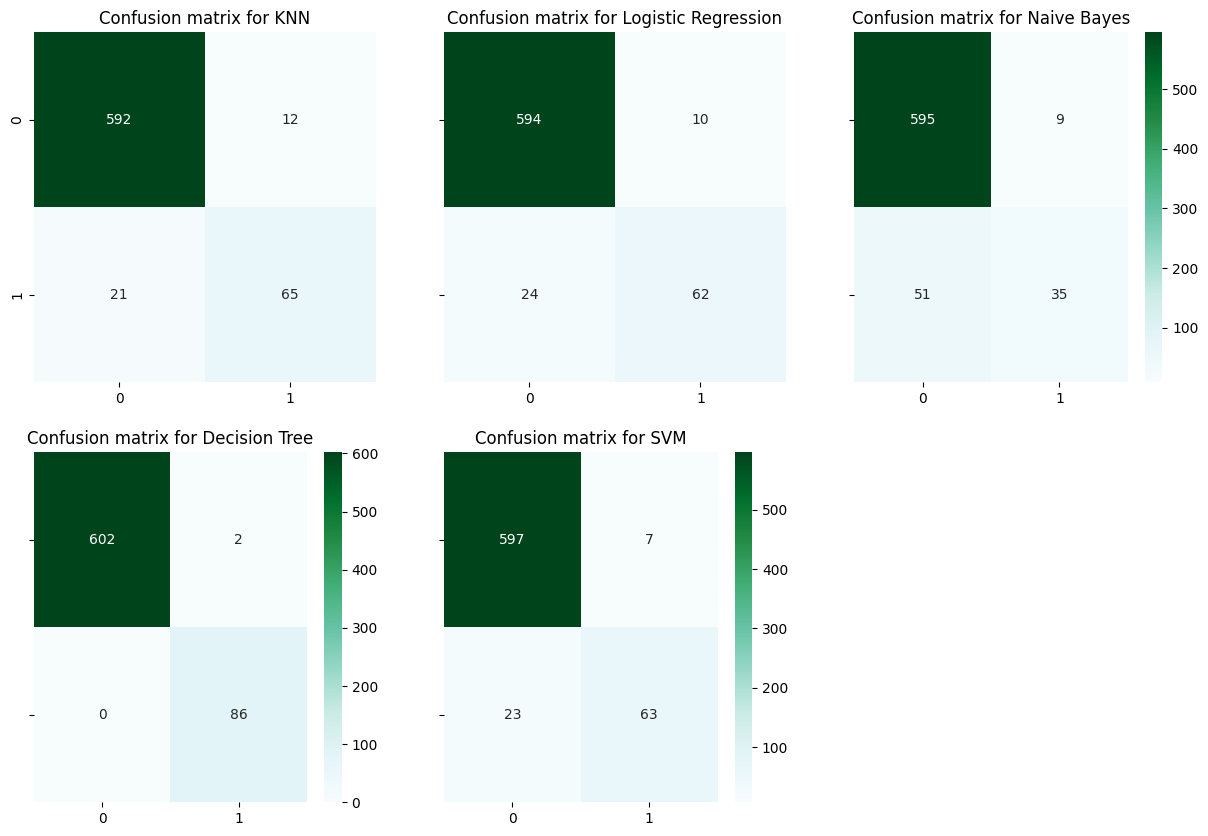

In [84]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
cm = confusion_matrix(y_train, y_train_hat_knn)
sns.heatmap(cm,annot=True, fmt='g', cbar=False, cmap='BuGn')
plt.title('Confusion matrix for KNN')

ax = plt.subplot(2,3,2)
cm = confusion_matrix(y_train, y_train_hat_logreg)
sns.heatmap(cm,annot=True, fmt='g', cbar=False, cmap='BuGn')
plt.title('Confusion matrix for Logistic Regression')
ax.set_yticklabels([])

ax = plt.subplot(2,3,3)
cm = confusion_matrix(y_train, y_train_hat_nb)
sns.heatmap(cm,annot=True, fmt='g', cmap='BuGn')
plt.title('Confusion matrix for Naive Bayes')
ax.set_yticklabels([])

ax = plt.subplot(2,3,4)
cm = confusion_matrix(y_train, y_train_hat_dt)
sns.heatmap(cm,annot=True, fmt='g', cmap='BuGn')
plt.title('Confusion matrix for Decision Tree')
ax.set_yticklabels([])

ax = plt.subplot(2,3,5)
cm = confusion_matrix(y_train, y_train_hat_svm)
sns.heatmap(cm,annot=True, fmt='g', cmap='BuGn')
plt.title('Confusion matrix for SVM')
ax.set_yticklabels([])

plt.show()

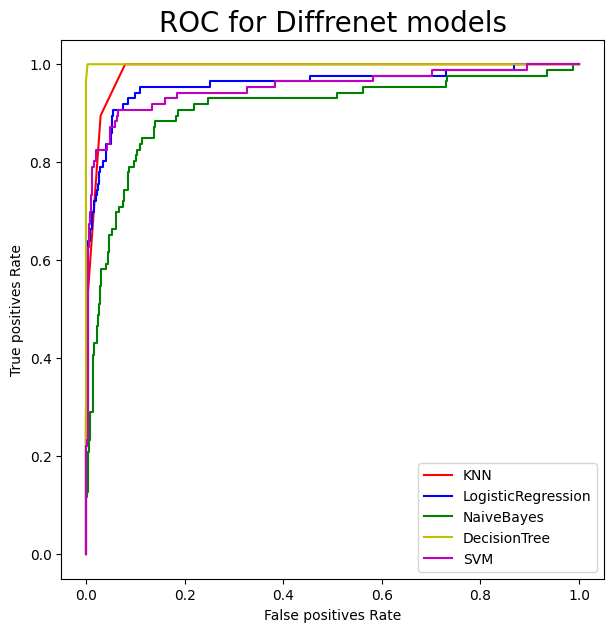

In [85]:
plt.figure(figsize=(7,7))
train_knn_fpr, train_knn_tpr, thresh = roc_curve(y_train, y_train_hat_knn_proba[:,1])
train_logreg_fpr, train_logreg_tpr, thresh = roc_curve(y_train, y_train_hat_logreg_proba[:,1])
train_nb_fpr, train_nb_tpr, thresh = roc_curve(y_train, y_train_hat_nb_proba[:,1])
train_dt_fpr, train_dt_tpr, thresh = roc_curve(y_train, y_train_hat_dt_proba[:,1])
train_svm_fpr, train_svm_tpr, thresh = roc_curve(y_train, y_train_hat_svm_proba[:,1])

plt.plot(train_knn_fpr, train_knn_tpr,'r', label='KNN')
plt.plot(train_logreg_fpr, train_logreg_tpr,'b', label='LogisticRegression')
plt.plot(train_nb_fpr, train_nb_tpr,'g', label='NaiveBayes')
plt.plot(train_dt_fpr, train_dt_tpr,'y', label='DecisionTree')
plt.plot(train_svm_fpr, train_svm_tpr,'m', label='SVM')

plt.title('ROC for Diffrenet models', size=20)
plt.xlabel("False positives Rate")
plt.ylabel("True positives Rate")
plt.legend()
plt.show()

### Metrics for Test set

In [86]:
metrics_test = {'Metric':['Accuracy', 'precision', 'recall', 'F1_score', 'AUC'],
                'KNN':[],
                'LogReg':[],
                'NB':[],
                'DecisionTree':[],
                'SVM':[]}
# Accuracy
metrics_test['KNN'].append(accuracy_score(y_test, y_test_hat_knn))
metrics_test['LogReg'].append(accuracy_score(y_test, y_test_hat_logreg))
metrics_test['NB'].append(accuracy_score(y_test, y_test_hat_nb))
metrics_test['DecisionTree'].append(accuracy_score(y_test, y_test_hat_dt))
metrics_test['SVM'].append(accuracy_score(y_test, y_test_hat_svm))
# precision
metrics_test['KNN'].append(precision_score(y_test, y_test_hat_knn))
metrics_test['LogReg'].append(precision_score(y_test, y_test_hat_logreg))
metrics_test['NB'].append(precision_score(y_test, y_test_hat_nb))
metrics_test['DecisionTree'].append(precision_score(y_test, y_test_hat_dt))
metrics_test['SVM'].append(precision_score(y_test, y_test_hat_svm))
# recall
metrics_test['KNN'].append(recall_score(y_test, y_test_hat_knn))
metrics_test['LogReg'].append(recall_score(y_test, y_test_hat_logreg))
metrics_test['NB'].append(recall_score(y_test, y_test_hat_nb))
metrics_test['DecisionTree'].append(recall_score(y_test, y_test_hat_dt))
metrics_test['SVM'].append(recall_score(y_test, y_test_hat_svm))
# F1_score
metrics_test['KNN'].append(f1_score(y_test, y_test_hat_knn))
metrics_test['LogReg'].append(f1_score(y_test, y_test_hat_logreg))
metrics_test['NB'].append(f1_score(y_test, y_test_hat_nb))
metrics_test['DecisionTree'].append(f1_score(y_test, y_test_hat_dt))
metrics_test['SVM'].append(f1_score(y_test, y_test_hat_svm))
# AUC
metrics_test['KNN'].append(roc_auc_score(y_test, y_test_hat_knn))
metrics_test['LogReg'].append(roc_auc_score(y_test, y_test_hat_logreg))
metrics_test['NB'].append(roc_auc_score(y_test, y_test_hat_nb))
metrics_test['DecisionTree'].append(roc_auc_score(y_test, y_test_hat_dt))
metrics_test['SVM'].append(roc_auc_score(y_test, y_test_hat_svm))
df_metrics = pd.DataFrame(metrics_test)
df_metrics

,Metric,KNN,LogReg,NB,DecisionTree,SVM
0,Accuracy,0.930636,0.959538,0.907514,0.976879,0.947977
1,precision,0.857143,0.941176,0.800000,0.846154,0.882353
2,recall,0.545455,0.727273,0.363636,1.000000,0.681818
3,F1_score,0.666667,0.820513,0.500000,0.916667,0.769231
4,AUC,0.766105,0.860325,0.675196,0.986755,0.834287


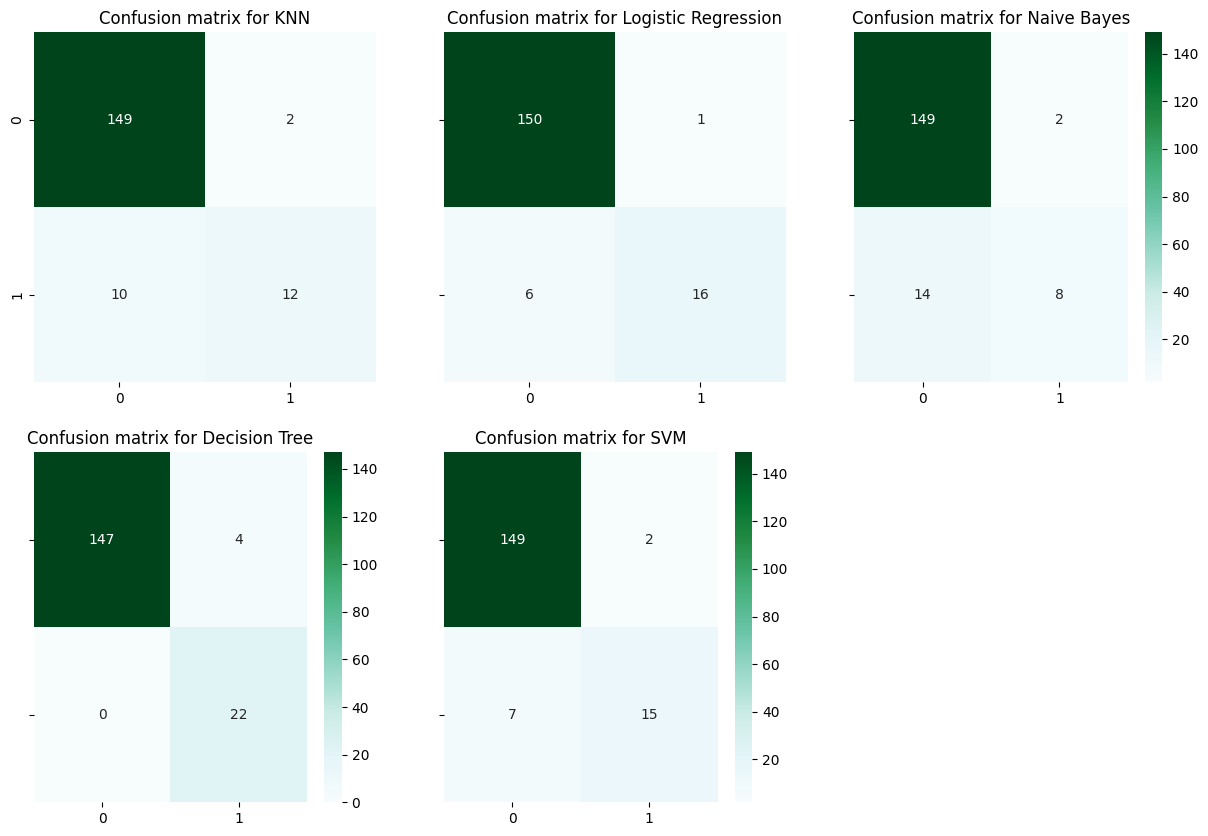

In [87]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
cm = confusion_matrix(y_test, y_test_hat_knn)
sns.heatmap(cm,annot=True, fmt='g', cbar=False, cmap='BuGn')
plt.title('Confusion matrix for KNN')

ax = plt.subplot(2,3,2)
cm = confusion_matrix(y_test, y_test_hat_logreg)
sns.heatmap(cm,annot=True, fmt='g', cbar=False, cmap='BuGn')
plt.title('Confusion matrix for Logistic Regression')
ax.set_yticklabels([])

ax = plt.subplot(2,3,3)
cm = confusion_matrix(y_test, y_test_hat_nb)
sns.heatmap(cm,annot=True, fmt='g', cmap='BuGn')
plt.title('Confusion matrix for Naive Bayes')
ax.set_yticklabels([])

ax = plt.subplot(2,3,4)
cm = confusion_matrix(y_test, y_test_hat_dt)
sns.heatmap(cm,annot=True, fmt='g', cmap='BuGn')
plt.title('Confusion matrix for Decision Tree')
ax.set_yticklabels([])

ax = plt.subplot(2,3,5)
cm = confusion_matrix(y_test, y_test_hat_svm)
sns.heatmap(cm,annot=True, fmt='g', cmap='BuGn')
plt.title('Confusion matrix for SVM')
ax.set_yticklabels([])

plt.show()

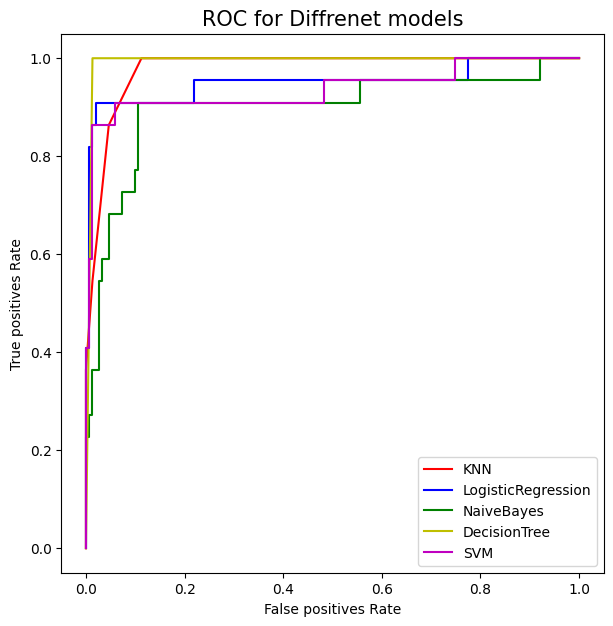

In [88]:
plt.figure(figsize=(7,7))
test_knn_fpr, test_knn_tpr, thresh = roc_curve(y_test, y_test_hat_knn_proba[:,1])
test_logreg_fpr, test_logreg_tpr, thresh = roc_curve(y_test, y_test_hat_logreg_proba[:,1])
test_nb_fpr, test_nb_tpr, test_ = roc_curve(y_test, y_test_hat_nb_proba[:,1])
test_dt_fpr, test_dt_tpr, thresh = roc_curve(y_test, y_test_hat_dt_proba[:,1])
test_svm_fpr, test_svm_tpr, thresh = roc_curve(y_test, y_test_hat_svm_proba[:,1])

plt.plot(test_knn_fpr, test_knn_tpr,'r', label='KNN')
plt.plot(test_logreg_fpr, test_logreg_tpr,'b', label='LogisticRegression')
plt.plot(test_nb_fpr, test_nb_tpr,'g', label='NaiveBayes')
plt.plot(test_dt_fpr, test_dt_tpr,'y', label='DecisionTree')
plt.plot(test_svm_fpr, test_svm_tpr,'m', label='SVM')

plt.title('ROC for Diffrenet models', size=15)
plt.xlabel("False positives Rate")
plt.ylabel("True positives Rate")
plt.legend()
plt.show()

-  The Decision Tree classifier outperforms other models with the highest accuracy, precision, recall, F1-score, and AUC. Logistic Regression also demonstrates strong overall performance. KNN and SVM compete closely, while Naive Bayes lags in precision and recall.
